# Forecasting Facebook Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

mpl.rcParams['figure.figsize']=(16,10)
pd.set_option('display.max_rows',500)

import plotly.graph_objects as go

In [1]:
#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet 

In [3]:
plt.style.use('fivethirtyeight')


# Trivial Forecast (rolling mean)

In [5]:
df=pd.DataFrame({'X':np.arange(0,10)})
df['y']=df.rolling(3).mean()

In [6]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


In [10]:
df_all=pd.read_csv("../data/processed/COVID_small_flat_table.csv",sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date':'ds','Germany':'y'})

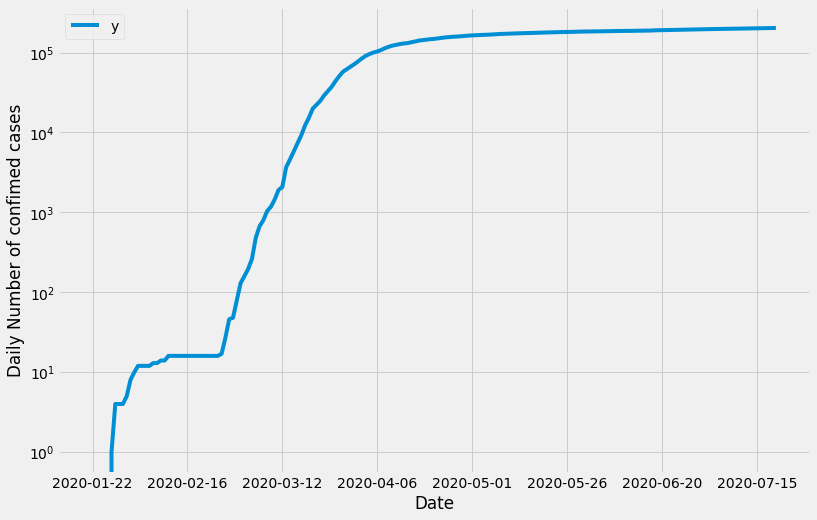

In [11]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [77]:
my_model=Prophet(growth='logistic')                      #(interval_width=0.95)

In [78]:
df['cap'] = 1000000      #remove this if using intervl/linear fitting
my_model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
future_dates=my_model.make_future_dataframe(periods=50,freq='D')
future_dates['cap']=1000000. #needed for logistic model
future_dates.tail()

,ds,cap
226,2020-09-04,1000000.0
227,2020-09-05,1000000.0
228,2020-09-06,1000000.0
229,2020-09-07,1000000.0
230,2020-09-08,1000000.0


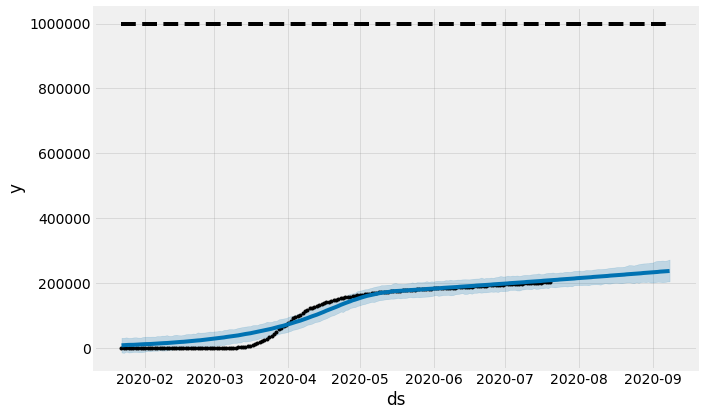

In [80]:
forecast=my_model.predict(future_dates) # forecast will contain entire data, in this case df and forecasted data
my_model.plot(forecast,uncertainty=True);

In [81]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig=plot_plotly(my_model,forecast) # This returns a plotly figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
    )
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)


In [82]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,8736.955563,1000000.0,-13437.412903,31617.987901,8736.955563,8736.955563,-241.786606,-241.786606,-241.786606,-241.786606,-241.786606,-241.786606,0.0,0.0,0.0,8495.168957
1,2020-01-23,9012.749671,1000000.0,-14688.202305,31573.115917,9012.749671,9012.749671,0.360197,0.360197,0.360197,0.360197,0.360197,0.360197,0.0,0.0,0.0,9013.109868
2,2020-01-24,9297.167950,1000000.0,-10946.737119,32949.167195,9297.167950,9297.167950,312.986746,312.986746,312.986746,312.986746,312.986746,312.986746,0.0,0.0,0.0,9610.154696
3,2020-01-25,9590.474847,1000000.0,-13660.529489,31250.206837,9590.474847,9590.474847,229.512665,229.512665,229.512665,229.512665,229.512665,229.512665,0.0,0.0,0.0,9819.987512
4,2020-01-26,9892.942584,1000000.0,-13094.683996,31466.159136,9892.942584,9892.942584,1.756830,1.756830,1.756830,1.756830,1.756830,1.756830,0.0,0.0,0.0,9894.699415


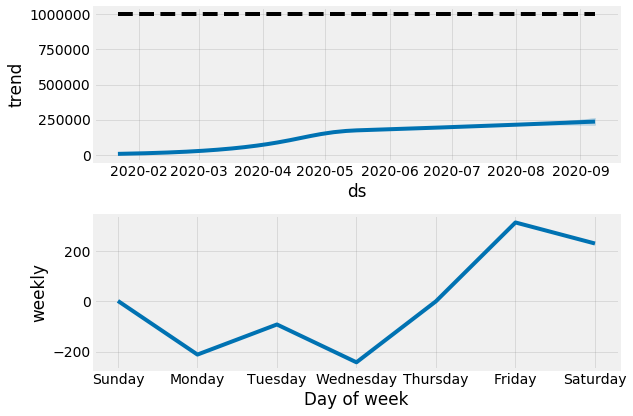

In [83]:
my_model.plot_components(forecast);#second graph shows the seasonality (weekly behavior)

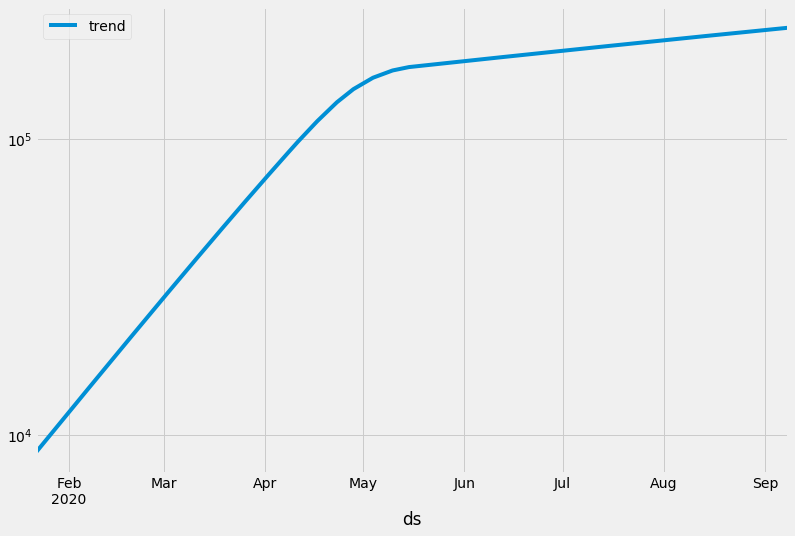

In [84]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True) #linear trend model with changepoint detection
#is used in facebook prophet. refer the third link in the start of the paper to read about this. section(3.1.2)

# Cross Validation

In [85]:
from fbprophet.diagnostics import cross_validation
df_cv=cross_validation(my_model,
                      initial='50 days', # we take the first 30 days for training
                      period='1 days',# every  days a new prediction run
                      horizon='7 days')#we predict 7days into the future

# the 'initial'(1-50) value is taken for training and predicts the 'horizon' number of days. The the window 
# moves my one day (2-51) and use it as training and predicts fr next 7 days.

INFO:fbprophet:Making 124 forecasts with cutoffs between 2020-03-12 00:00:00 and 2020-07-13 00:00:00


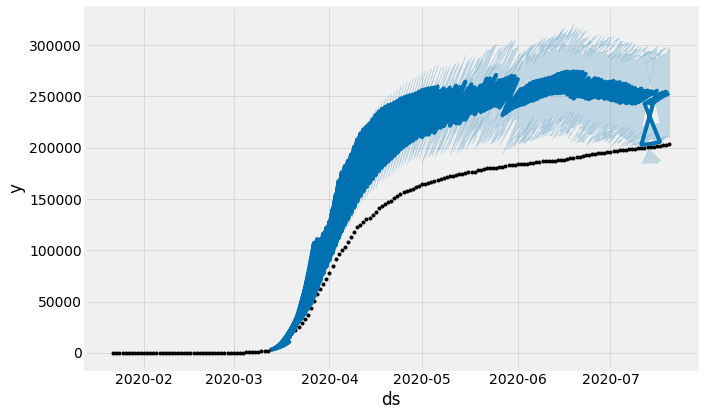

In [98]:
my_model.plot(df_cv,uncertainty=True);

In [94]:
df_cv.sort_values(by=['cutoff','ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
0,2020-03-13,2816.341953,2754.351123,2877.180928,3675,2020-03-12,1 days
1,2020-03-14,3515.754196,3454.193306,3578.194117,4585,2020-03-12,2 days
2,2020-03-15,4402.470418,4344.454708,4462.760273,5795,2020-03-12,3 days
3,2020-03-16,5481.024475,5412.158616,5543.581904,7272,2020-03-12,4 days
4,2020-03-17,6843.377647,6783.337986,6907.603368,9257,2020-03-12,5 days
5,2020-03-18,8559.853444,8499.404275,8626.880547,12327,2020-03-12,6 days
6,2020-03-19,10666.626132,10606.552008,10727.657392,15320,2020-03-12,7 days
7,2020-03-14,4314.452877,4202.179433,4424.714104,4585,2020-03-13,1 days
8,2020-03-15,5600.251933,5492.699336,5717.201833,5795,2020-03-13,2 days
9,2020-03-16,7234.708052,7128.234418,7348.109304,7272,2020-03-13,3 days


In [87]:
from fbprophet.diagnostics import performance_metrics
df_p=performance_metrics(df_cv)  # shows the performance metrics for the horizon number of days
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,2.083048e+09,45640.424088,40911.080715,0.249356,0.279882,0.024194
1,2 days,2.460973e+09,49608.198592,45290.355048,0.281925,0.313289,0.016129
2,3 days,2.912446e+09,53967.078197,50044.612322,0.317704,0.347336,0.016129
3,4 days,3.454425e+09,58774.355672,55216.176227,0.356970,0.385278,0.016129
4,5 days,4.109405e+09,64104.638384,60858.980353,0.400175,0.414256,0.008065
5,6 days,4.904367e+09,70031.183053,67010.751008,0.447268,0.441412,0.008065
6,7 days,5.876630e+09,76659.179954,73721.451042,0.498300,0.468343,0.008065


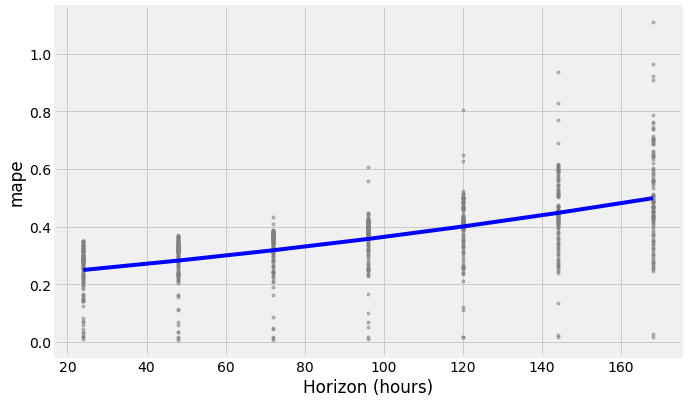

In [88]:
from fbprophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,'mape')


# Diagonal Plot
### gives a good understanding for the under and over estimation w.r.t. magnitude 
Every forecast model should be checked by a diagonal plot. A diagonal plot is used to fid out distortionor bias in underestimating or overestimating

In [89]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff #subtracting the dates
date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [95]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
6,2020-03-19,10666.626132,10606.552008,10727.657392,15320,2020-03-12,7 days
13,2020-03-20,20386.697406,20277.527472,20491.489586,19848,2020-03-13,7 days
20,2020-03-21,29345.986720,29236.717933,29456.833255,22213,2020-03-14,7 days
27,2020-03-22,37137.157964,37026.975848,37248.850434,24873,2020-03-15,7 days
34,2020-03-23,44559.662395,44448.830779,44668.806752,29056,2020-03-16,7 days


In [91]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

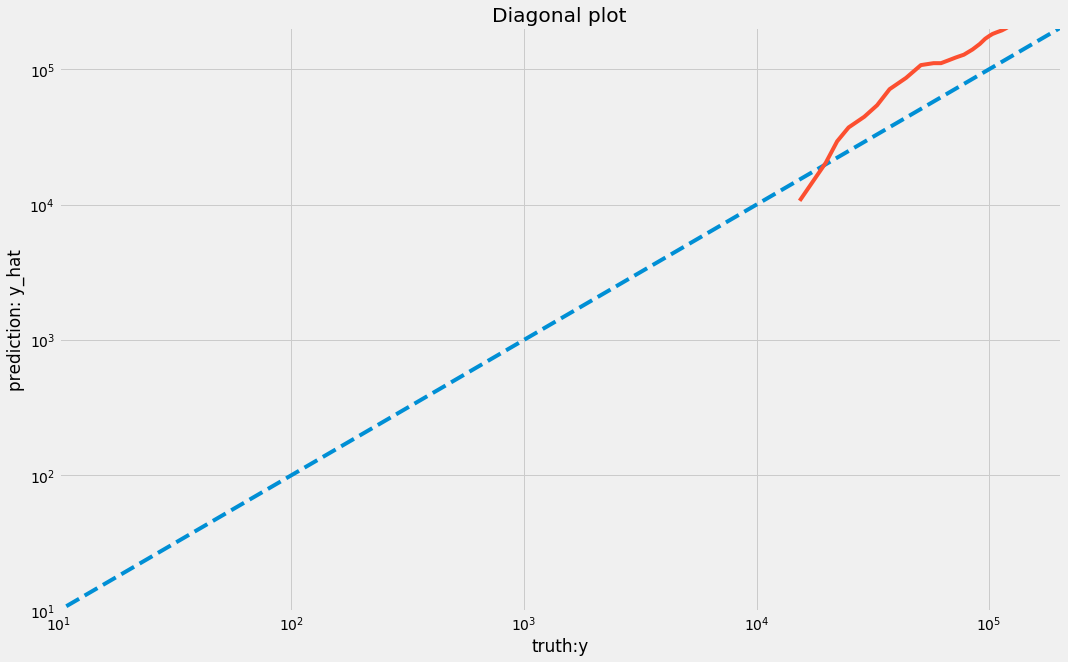

In [93]:
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)
ax.set_title('Diagonal plot')
ax.set_ylim(10,max(y))
ax.set_xlabel('truth:y')
ax.set_ylabel('prediction: y_hat')
ax.set_yscale('log')
ax.set_xlim(10,max(y))
ax.set_xscale('log')
ax.legend(loc='best');

# Trivial Forecast


In [99]:
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [100]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean 

An other standard forecast is the exponentially-weighted moving average,
check pandas.ewma

In [102]:
df_trivial['y_mean_3']=df_trivial['y'].rolling(3).mean()

In [104]:
df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 168.0626838435285


,ds,y,y_mean_r3,cutoff,y_hat,horizon,y_mean_3
0,2020-01-22,0,NaN,NaT,NaN,NaT,NaN
1,2020-01-23,0,NaN,NaT,NaN,NaT,NaN
2,2020-01-24,0,0.000000,NaT,NaN,NaT,0.000000
3,2020-01-25,0,0.000000,NaT,NaN,NaT,0.000000
4,2020-01-26,0,0.000000,NaT,NaN,NaT,0.000000
5,2020-01-27,1,0.333333,NaT,NaN,NaT,0.333333
6,2020-01-28,4,1.666667,NaT,NaN,NaT,1.666667
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days,3.000000
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days,4.000000
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days,4.333333
